Leídos 299 registros del CSV
⚠️ Se descartaron 2 videos con tiempos inconsistentes: [77, 79]...

Resumen general:
 - videos_procesados: 89.00
 - duracion_promedio_s: 76.01
 - duracion_min_s: 25.00
 - duracion_max_s: 312.00
 - desviacion_std_s: 40.37


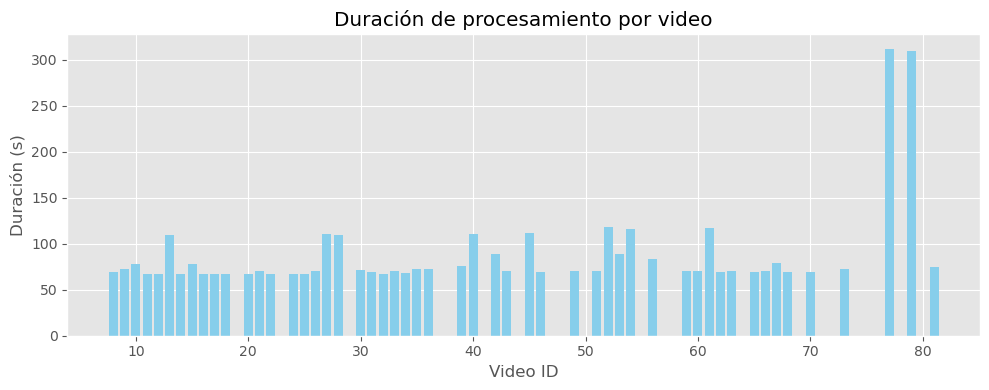

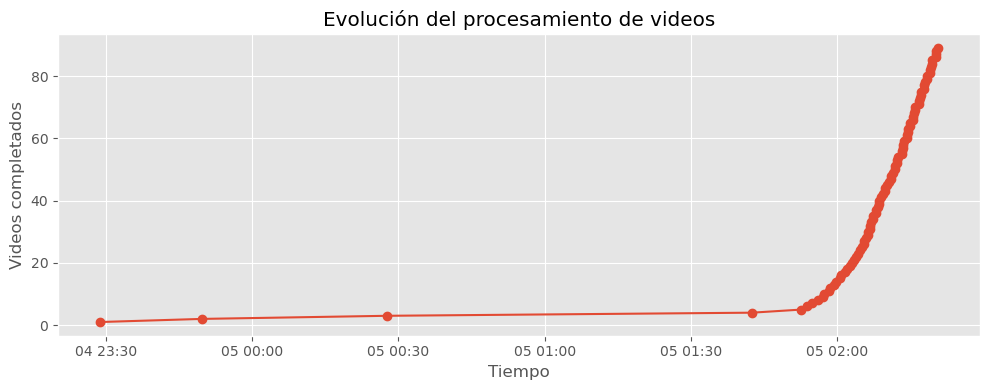

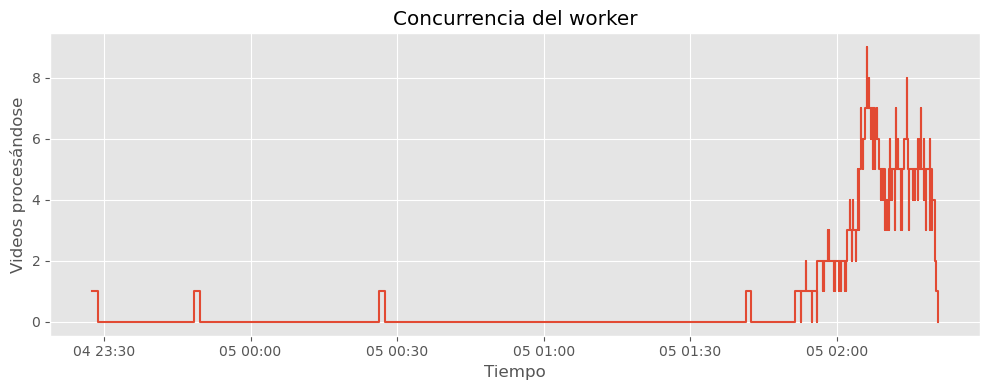

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime

# === 1. Leer logs ===
# CloudWatch export is CSV-style: timestamp,message,logStreamName
df_raw = pd.read_csv("worker-logs-e4.csv")

# Optional sanity check
print(f"Leídos {len(df_raw)} registros del CSV")

# === 2. Expresiones regulares ===
pattern_start = re.compile(r"\[Video (\d+)\] Started processing at: ([\d\-T:.Z]+)")
pattern_end = re.compile(r"\[Video (\d+)\] Completed processing at: ([\d\-T:.Z]+) \(Duration: ([\d\.smh]+)\)")

data = []

for msg in df_raw["message"]:
    if not isinstance(msg, str):  # skip NaN or non-string messages
        continue

    start_match = pattern_start.search(msg)
    end_match = pattern_end.search(msg)

    if start_match:
        video_id = int(start_match.group(1))
        start_time = datetime.fromisoformat(start_match.group(2).replace("Z", "+00:00"))
        data.append({"video_id": video_id, "event": "start", "time": start_time})
    elif end_match:
        video_id = int(end_match.group(1))
        end_time = datetime.fromisoformat(end_match.group(2).replace("Z", "+00:00"))
        duration_str = end_match.group(3)
        data.append({"video_id": video_id, "event": "end", "time": end_time, "duration": duration_str})


df = pd.DataFrame(data)

# === 3. Filtrar solo videos con start y end ===
has_start = df[df["event"] == "start"]["video_id"].unique()
has_end = df[df["event"] == "end"]["video_id"].unique()
valid_videos = set(has_start).intersection(has_end)

df = df[df["video_id"].isin(valid_videos)]

# === 4. Calcular duraciones ===
starts = df[df["event"] == "start"][["video_id", "time"]].rename(columns={"time": "start_time"})
ends = df[df["event"] == "end"][["video_id", "time"]].rename(columns={"time": "end_time"})

merged = pd.merge(starts, ends, on="video_id", how="inner")
merged["duration_s"] = (merged["end_time"] - merged["start_time"]).dt.total_seconds()

# Filtrar duraciones inválidas
invalid_videos = merged[merged["duration_s"] < 0]["video_id"].tolist()
merged = merged[merged["duration_s"] >= 0]

if invalid_videos:
    print(f"⚠️ Se descartaron {len(invalid_videos)} videos con tiempos inconsistentes: {invalid_videos[:10]}...")

# === 5. Métricas ===
summary = {
    "videos_procesados": len(merged),
    "duracion_promedio_s": merged["duration_s"].mean(),
    "duracion_min_s": merged["duration_s"].min(),
    "duracion_max_s": merged["duration_s"].max(),
    "desviacion_std_s": merged["duration_s"].std()
}

print("\nResumen general:")
for k, v in summary.items():
    print(f" - {k}: {v:.2f}" if isinstance(v, (int, float)) else f" - {k}: {v}")

# === 6. Gráficos ===
plt.style.use("ggplot")

# (a) Duración por video
plt.figure(figsize=(10, 4))
plt.bar(merged["video_id"], merged["duration_s"], color="skyblue")
plt.xlabel("Video ID")
plt.ylabel("Duración (s)")
plt.title("Duración de procesamiento por video")
plt.tight_layout()
plt.show()

# (b) Throughput
merged_sorted = merged.sort_values("end_time")
merged_sorted["count"] = range(1, len(merged_sorted) + 1)

plt.figure(figsize=(10, 4))
plt.plot(merged_sorted["end_time"], merged_sorted["count"], marker="o")
plt.xlabel("Tiempo")
plt.ylabel("Videos completados")
plt.title("Evolución del procesamiento de videos")
plt.tight_layout()
plt.show()

# (c) Concurrencia
timeline = []
for _, row in merged.iterrows():
    timeline.append((row["start_time"], 1))
    timeline.append((row["end_time"], -1))

timeline_df = pd.DataFrame(timeline, columns=["time", "change"]).sort_values("time")
timeline_df["active"] = timeline_df["change"].cumsum()

plt.figure(figsize=(10, 4))
plt.step(timeline_df["time"], timeline_df["active"], where="post")
plt.xlabel("Tiempo")
plt.ylabel("Videos procesándose")
plt.title("Concurrencia del worker")
plt.tight_layout()
plt.show()
